In [1]:
from transformers import GPT2LMHeadModel

In [3]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
sd = model.state_dict()

for k, v in sd.items():
    print(k, v.shape)


transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [10]:
sd['transformer.wte.weight'].view(-1)[:10]


tensor([-0.1101, -0.0393,  0.0331,  0.1338, -0.0485, -0.0789, -0.2398, -0.0895,
         0.0253, -0.1074])

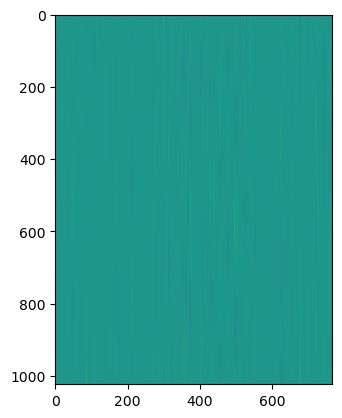

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(sd['transformer.wpe.weight'])
plt.show()

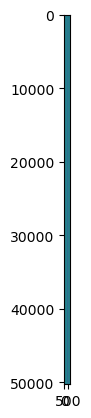

In [20]:
plt.imshow(sd['transformer.wte.weight'])

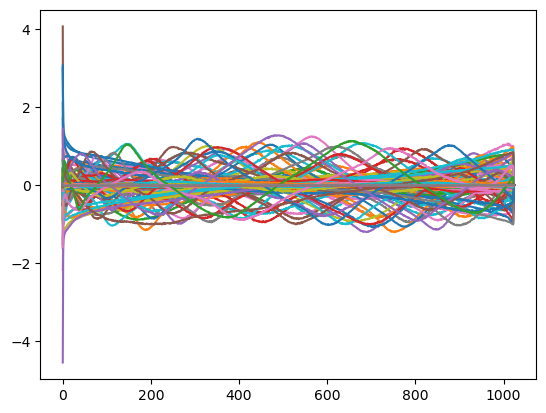

In [24]:
# visualization of how position embeddings learn the sinusoidal representations
plt.plot(sd['transformer.wpe.weight'][:, :])
plt.show()


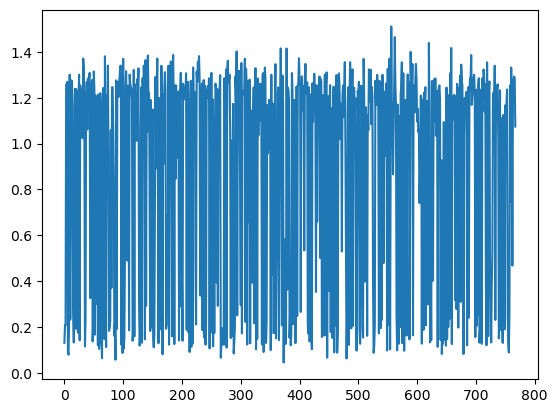

In [28]:
# transformer weight visualization
plt.plot(sd['transformer.h.0.ln_2.weight'])

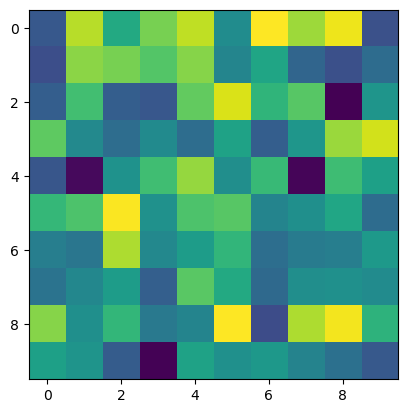

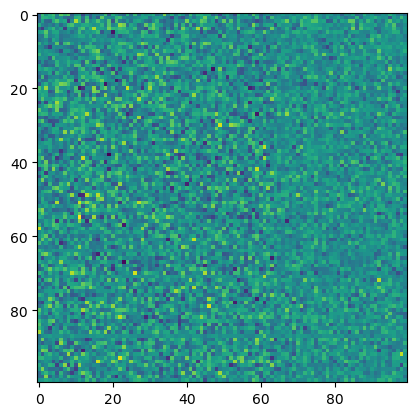

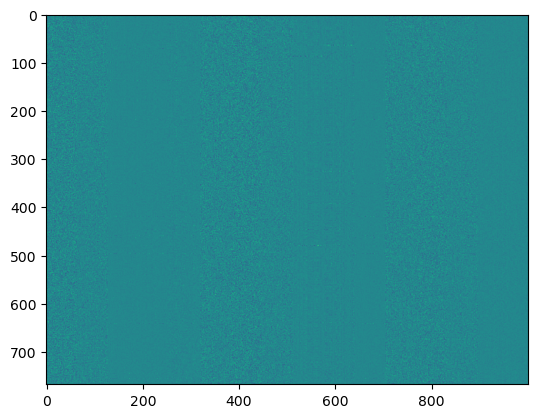

In [32]:
# different levels of granularity
plt.imshow(sd['transformer.h.1.attn.c_attn.weight'][:10, :10])
plt.show()
plt.imshow(sd['transformer.h.1.attn.c_attn.weight'][:100, :100])
plt.show()
plt.imshow(sd['transformer.h.1.attn.c_attn.weight'][:1000, :1000])
plt.show()

In [33]:
from transformers import pipeline, set_seed


In [36]:
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("spongebob squarepants", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'spongebob squarepants: what i do you want me to do wangmees: why you want to wangmees: what'},
 {'generated_text': 'spongebob squarepants.\n\nBut if the mayor and the police department are not serious about protecting the free speech of some citizens these days'},
 {'generated_text': "spongebob squarepants, then there's a little black dot on the floor. It's a square that looks different than the ones you'd"},
 {'generated_text': 'spongebob squarepants, pouches, naturals, tuxedos and various other paraphernalia:\n\n\n- The'},
 {'generated_text': "spongebob squarepants. I don't know why it doesn't. Just a good example of the types of things that are going on."}]

evidently this boy is not very smart when it comes to spongebob squarepants. this must be fixed immediately.


In [44]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
enc.encode("spongebob squarepants")



[2777, 14220, 65, 672, 6616, 38895]

In [45]:
import torch
j

In [48]:
mask = torch.tril(torch.ones(500, 500), diagonal=1)
# fill negative inf
mask = mask.masked_fill(mask == 0, float('-inf'))



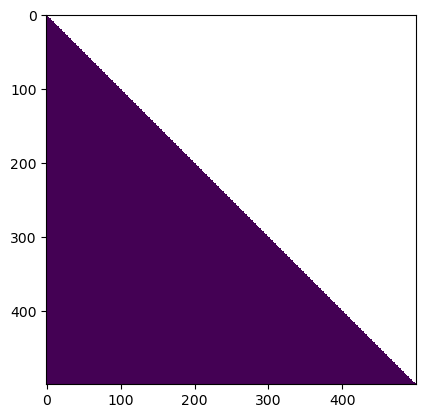

In [49]:
import matplotlib.pyplot as plt
plt.imshow(mask)



In [50]:
sentence = "hi im a sentence"

In [51]:
encoder = tiktoken.get_encoding("gpt2")
encoded = encoder.encode(sentence)



In [52]:
encoded

[5303, 545, 257, 6827]